In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras import backend as K

In [ ]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.5.0


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
IMAGE_SIZE = 256
EPOCHS = 100
BATCH = 128
LR = 1e-3

PATH = "./TO_VINOD_V2_12OCT2020/"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/skeyenet-master/"
%cd gdrive/My\ Drive/skeyenet-master/

Mounted at /content/gdrive/
/content/gdrive/My Drive/skeyenet-master


In [ ]:
%ls

Data/    output.png        road_mapper_final.h5
Images/  README.md         Src/
LICENSE  requirements.txt  TO_VINOD_V2_12OCT2020/


In [ ]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "RASTER/*")))
    masks = sorted(glob(os.path.join(path, "MASKS/*")))
    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

# didnt undertstand this
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  333
Validation data:  41
Testing data:  41


In [ ]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

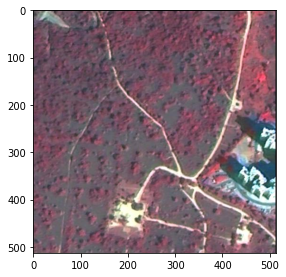

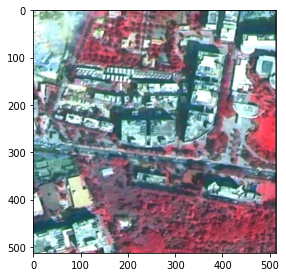

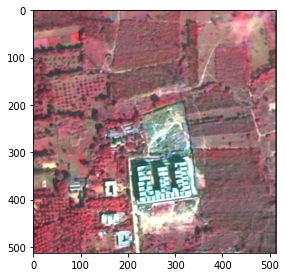

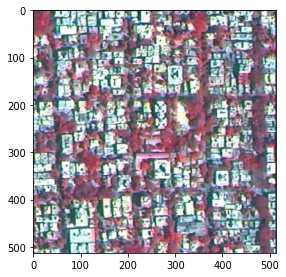

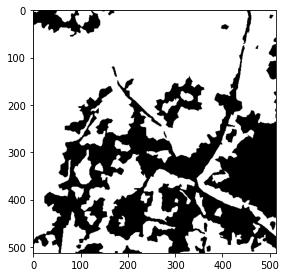

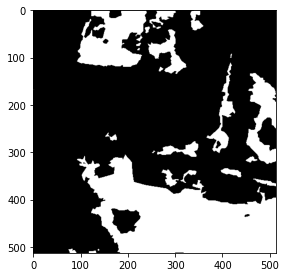

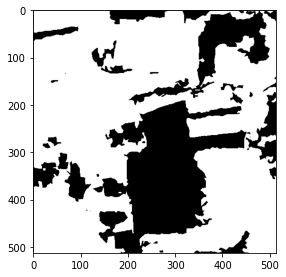

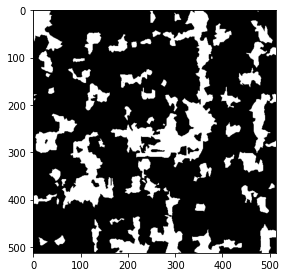

In [ ]:
fig = plt.figure(figsize=(20, 16))
x, y = 5,4
a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

fig = plt.figure(figsize=(20, 16))
x, y = 5,4
a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))

fig = plt.figure(figsize=(20, 16))
x, y = 5,4
a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))

fig = plt.figure(figsize=(20, 16))
x, y = 5,4
a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))

fig = plt.figure(figsize=(20, 16))
x, y = 5,4
a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

fig = plt.figure(figsize=(20, 16))
x, y = 5,4
a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))

fig = plt.figure(figsize=(20, 16))
x, y = 5,4
a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))

fig = plt.figure(figsize=(20, 16))
x, y = 5,4
a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))


## Model

In [ ]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
model = model()
model.summary()

2023424/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
_______________________________

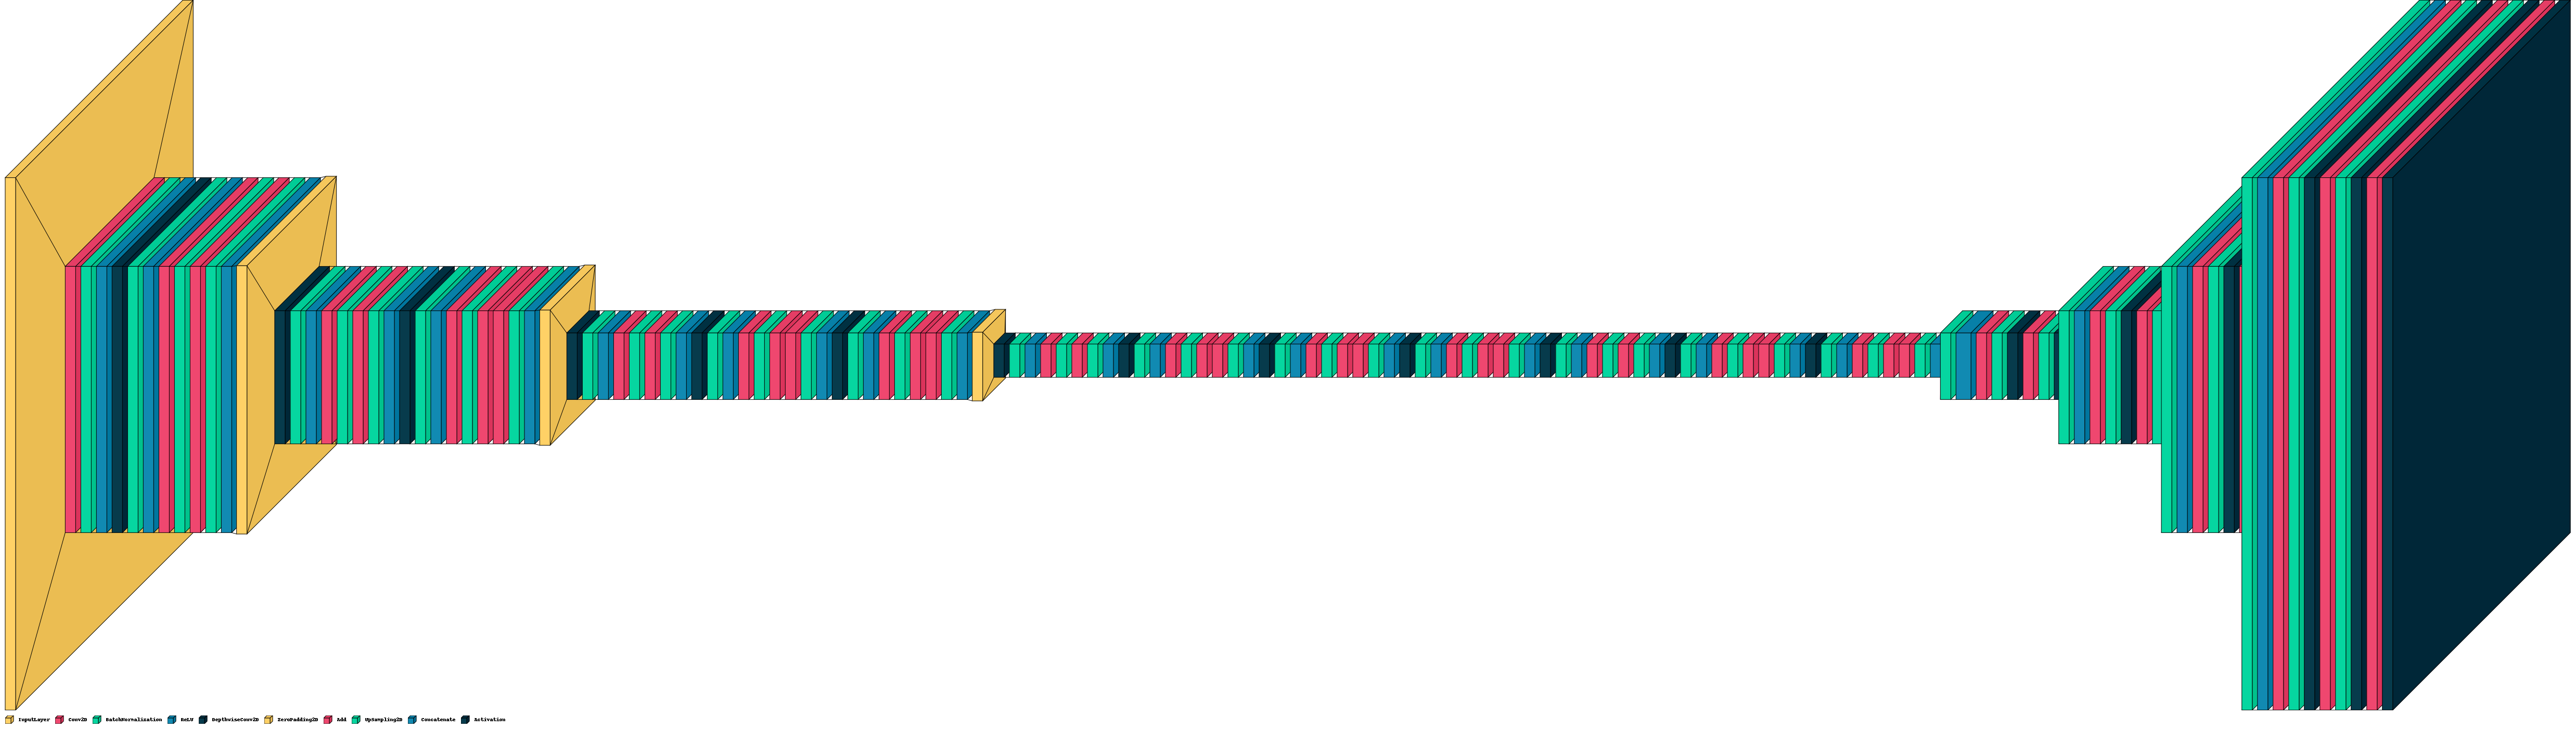

In [ ]:
pip install visualkeras
import visualkeras
visualkeras.layered_view(model,legend=True)

## Metrics

In [ ]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Training

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [ ]:
opt = tf.keras.optimizers.Adam(LR)
metrics = [dice_coef, Recall(), Precision(),Accuracy()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/skeyenet-master/road_mapper_final.h5', custom_objects={'dice_loss': dice_loss,'dice_coef':dice_coef})

In [ ]:
train_steps = len(train_x)//BATCH# integer division
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0: # to add another block for the remainders if they dont divide the batch size
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1
    

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/100
3/3 [==============================] - 2s 623ms/step - loss: 0.0770 - dice_coef: 0.9230 - recall_4: 0.9107 - precision_4: 0.9435 - accuracy: 0.0000e+00 - val_loss: 0.1335 - val_dice_coef: 0.8665 - val_recall_4: 0.8779 - val_precision_4: 0.8697 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 2s 646ms/step - loss: 0.0767 - dice_coef: 0.9233 - recall_4: 0.9071 - precision_4: 0.9459 - accuracy: 0.0000e+00 - val_loss: 0.1335 - val_dice_coef: 0.8665 - val_recall_4: 0.8782 - val_precision_4: 0.8695 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 2s 648ms/step - loss: 0.0813 - dice_coef: 0.9187 - recall_4: 0.9145 - precision_4: 0.9334 - accuracy: 0.0000e+00 - val_loss: 0.1335 - val_dice_coef: 0.8665 - val_recall_4: 0.8786 - val_precision_4: 0.8691 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 2s 654ms/step - loss: 0.0714 - dice_coef: 0.9310 - recall_4: 0.9111 - precision_4: 0.9515 - accuracy

In [ ]:
model.save("road_mapper_final.h5")

## Evaluation

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

1/1 [==============================] - 1s 578ms/step - loss: 0.1291 - dice_coef: 0.8709 - recall_4: 0.8797 - precision_4: 0.8758 - accuracy: 0.0000e+00


[0.12914061546325684,
 0.8708593845367432,
 0.8796709775924683,
 0.875764012336731,
 0.0]

## Results

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_gray(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

# didnt understand this
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [ ]:
# didnt understand this
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

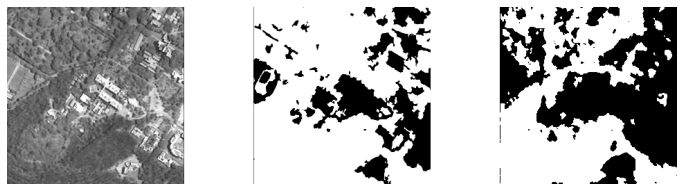

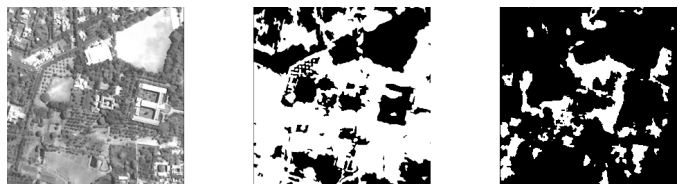

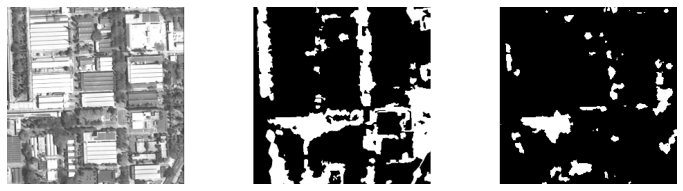

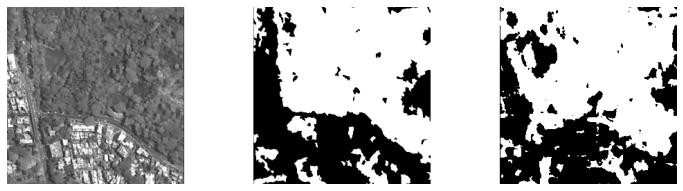

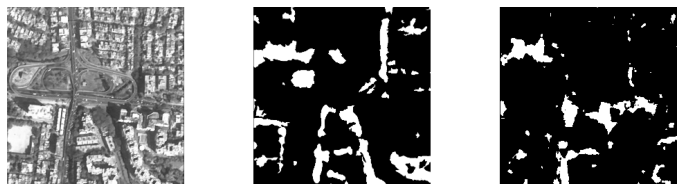

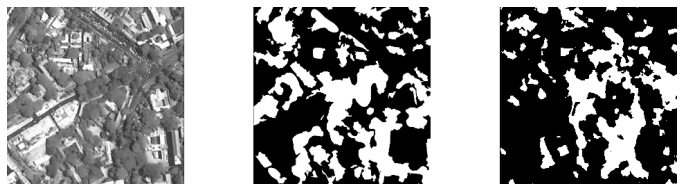

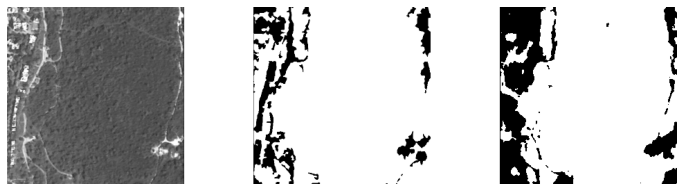

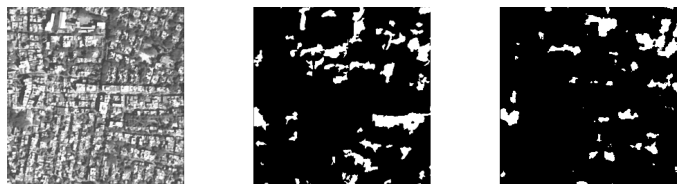

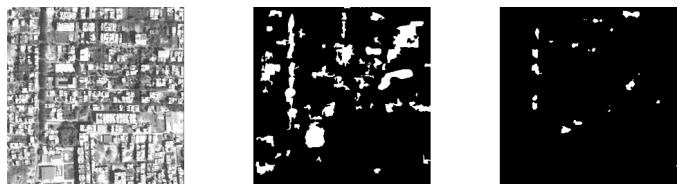

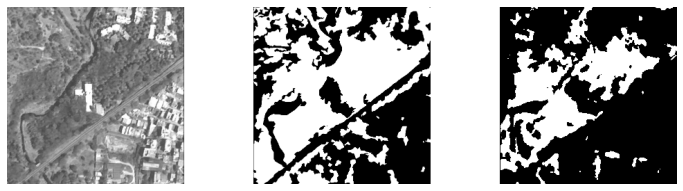

In [ ]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    ccc=x
    x = read_image(x)
    y = read_mask(y)
    x1=read_gray(ccc)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 100, 3))
    all_images = [
        x1, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    plt.axis('off')
    imgplot = plt.imshow(image)